In [72]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row
output_notebook()
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

Loading BokehJS ...

In [73]:
train = pd.read_csv('data/train.csv')
train = train.replace('\\N',np.NAN)
n,p = train.shape

In [74]:
def traitement_types(df):
    train_ = df.copy()
    
    for c in train_.columns:
        if 'crd_' in c or c in ['CRD','IMPAYES_DEBUT','age','adulte_foyer']:
            train_[c] = pd.to_numeric(train[c], errors='coerce')
        
    train_.moy_eco_jour = train_.moy_eco_jour.str.replace(',', '.', regex=False).astype(float)
    train_.RAV_UC = train_.RAV_UC.str.replace(',', '.', regex=False).astype(float)
    
    train_['Date'] = pd.to_datetime(train_.year.astype(str) + '-' + train_.month.astype(str), format='%Y-%m')
    train_ = train_.drop(columns=['year','month'])
    
    return train_


In [75]:
def trancheAge(x):
    age = x.age
    if age < 25:
        return '<25ans'

    elif age >= 25 and age <= 34:
        return  '25-34ans'

    elif age >= 35 and age <= 44:
        return  '35-44ans'

    elif age >= 45 and age <= 54:
        return  '45-54ans'

    elif age >= 55 and age <= 64:
        return  '55-64ans'

    elif age >= 65 and age <= 74:
        return  '65-74ans'

    elif age >= 75:
        return '>75ans'
    
    
def traitement_na(df):
    train_ = df.copy()
    
    train_ = train_.replace('Non Renseigne', np.NAN)
    for CRD in train.columns.tolist():
        if 'crd_' in CRD:
            train_[CRD] = train_[CRD].fillna(0)
    
    for p in train_.PROF.unique():
        med = train_.loc[train_.PROF == p].age.median()
        train_.loc[train_.PROF == p, 'age'] = train_.loc[train_.PROF == p, 'age'].fillna(med)
    
    train_.tranche_age = train_.apply(lambda x: trancheAge(x), axis=1)
    
    train_ = train_.drop(columns=['IMPAYES_DEBUT'])
    
    train_.gain_mediation = train_.gain_mediation.fillna(0).astype(int)
    
    train_.cat_impayes = train_.cat_impayes.fillna('Inconnu')
    
    train_ = train_.dropna()
    
    return train_

In [76]:
train = traitement_types(train)
train = traitement_na(train)

cols_categorielles = list(train.dtypes[train.dtypes == 'object'].to_dict().keys())

for cc in cols_categorielles:
    cat_dtype = pd.api.types.CategoricalDtype(categories=train[cc].unique().tolist(), ordered=False)
    train[cc] = train[cc].astype(cat_dtype)

train.shape


(3677, 42)

# I - Edit train

Nous pouvons définir les types d'orientation comme colonne afin de distinguer (dans la corrélation), quelle features influe sur chaque type d'Orientation.

In [77]:
or_dummies = pd.get_dummies(train.ORIENTATION)
train[['Surendettement','Mediation','Accompagnement','Aucune','Microcredit','Autres Procédures Collectives']]=or_dummies


In [78]:
train

,id,STRUCTURE PRESCRIPTRICE,PLATEFORME,region,ORIENTATION,NATURE_DIFF,age,tranche_age,situation,adulte_foyer,...,crd_decouvert,moy_eco_jour,cat_moy_eco_jour,Date,Surendettement,Mediation,Accompagnement,Aucune,Microcredit,Autres Procédures Collectives
0,1550,PRESCRIPTEUR35,bancaire,BOURGOGNE FRANCHE COMTE,Surendettement,Surendettement,68.0,65-74ans,celibataire,1.0,...,0.0,2.533330,"0a2,99€",2015-07-01,1,0,0,0,0,0
1,2249,PRESCRIPTEUR16,bancaire,OCCITANIE,Mediation,Endettement,68.0,65-74ans,marie,2.0,...,0.0,-3.316670,Négatif,2016-02-01,0,1,0,0,0,0
2,2670,PRESCRIPTEUR18,social,PROVENCE-ALPES-COTE-D'AZUR,Accompagnement,Endettement,45.0,45-54ans,celibataire,1.0,...,0.0,-24.766700,Négatif,2016-04-01,0,0,1,0,0,0
3,1102,PRESCRIPTEUR6,bancaire,BRETAGNE,Mediation,Multiendettement,68.0,65-74ans,divorce,1.0,...,0.0,29.566700,15€et+,2014-11-01,0,1,0,0,0,0
4,7069,PRESCRIPTEUR23,social,NOUVELLE AQUITAINE,Accompagnement,Difficultés de Gestion,24.0,<25ans,concubinage,2.0,...,0.0,-19.150000,Négatif,2018-09-01,0,0,1,0,0,0
5,7604,PRESCRIPTEUR37,social,AUVERGNE RHONE ALPES,Accompagnement,Impayés,29.0,25-34ans,marie,2.0,...,0.0,-9.311110,Négatif,2018-12-01,0,0,1,0,0,0
6,7234,PRESCRIPTEUR40,social,OCCITANIE,Accompagnement,Endettement,62.0,55-64ans,marie,2.0,...,0.0,-16.233300,Négatif,2018-10-01,0,0,1,0,0,0
7,1198,PRESCRIPTEUR32,bancaire,ILE-DE-FRANCE,Mediation,Surendettement,45.0,45-54ans,concubinage,2.0,...,0.0,4.416670,"3a5,99€",2015-01-01,0,1,0,0,0,0
8,3102,PRESCRIPTEUR20,social,HAUTS DE France,Accompagnement,Impayés,45.0,45-54ans,celibataire,1.0,...,0.0,-2.133330,Négatif,2016-07-01,0,0,1,0,0,0
9,3854,PRESCRIPTEUR10,bancaire,PAYS DE LA LOIRE,Surendettement,Cessation Paiement,45.0,45-54ans,concubinage,2.0,...,0.0,13.750000,"10a14,99€",2016-12-01,1,0,0,0,0,0


# I - Kmeans

In [79]:
from sklearn.cluster import KMeans

In [80]:
non_cat = train.drop(columns=cols_categorielles+['Date'])
features = non_cat.drop(columns=['id'])

crd_cols = [c for c in features.columns if 'crd_' in c]
nb_cols = [c for c in features.columns if 'nb_' in c]

features = features.drop(columns=nb_cols)

In [81]:
features.head()

,age,adulte_foyer,pers_a_charge,REVENUS,CHARGES,CREDITS,RAV_ouverture,RAV_UC,CRD,gain_mediation,...,crd_rac,crd_autres,crd_decouvert,moy_eco_jour,Surendettement,Mediation,Accompagnement,Aucune,Microcredit,Autres Procédures Collectives
0,68.0,1.0,0,1045,500,469,76,76.000,11600.0,0,...,0.0,0.0,0.0,2.53333,1,0,0,0,0,0
1,68.0,2.0,0,2366,665,1900,-199,-132.667,44838.0,0,...,0.0,0.0,0.0,-3.31667,0,1,0,0,0,0
2,45.0,1.0,0,1350,956,181,213,213.000,5696.0,0,...,0.0,3996.0,0.0,-24.76670,0,0,1,0,0,0
3,68.0,1.0,0,2023,568,568,887,887.000,12750.0,0,...,0.0,0.0,0.0,29.56670,0,1,0,0,0,0
4,24.0,2.0,0,2100,1382,485,233,155.333,14337.0,0,...,0.0,0.0,0.0,-19.15000,0,0,1,0,0,0


(23, 23)


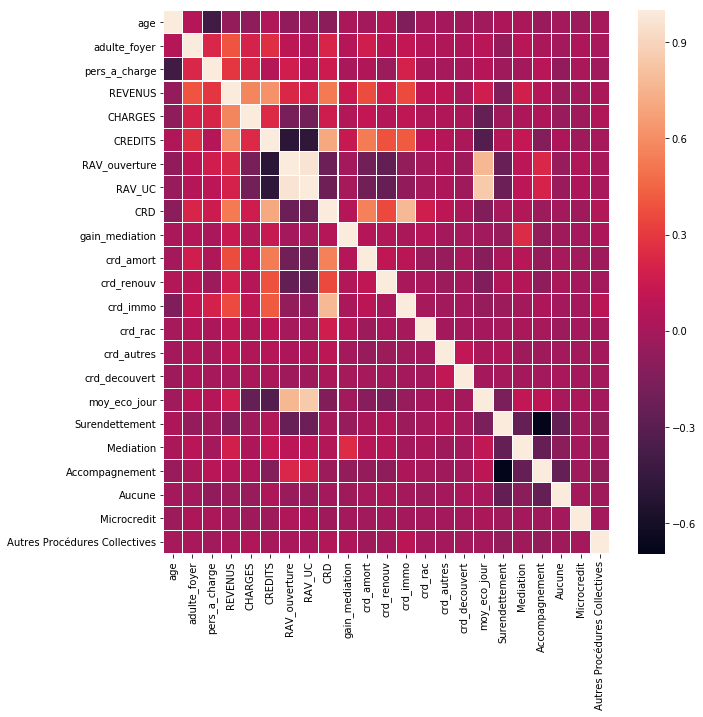

In [82]:
corr = features.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.05, ax=ax)

/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


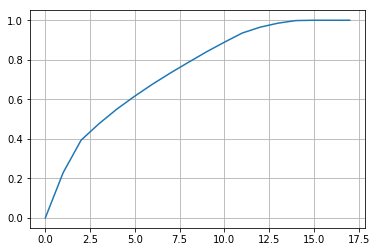

In [57]:
sc = StandardScaler() 
n,p = features.shape
Z = sc.fit_transform(features)
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z) 

taux = acp.explained_variance_ratio_ 
taux = np.insert(taux,0,0)
plt.plot(taux.cumsum())
plt.grid(True)

In [58]:
taux[1:].round(2)

array([0.23, 0.16, 0.08, 0.07, 0.07, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05,
       0.03, 0.02, 0.01, 0.  , 0.  , 0.  ])

In [60]:
points = pd.DataFrame(coord)
a = 0.05

# Axes 0 et 1
f1 = figure(width=320, plot_height=320, title="Axes 0 et 1")
f1.scatter(x=points[0], y=points[1], alpha=a)

# Axes 0 et 2
f2 = figure(width=320, plot_height=320, title="Axes 0 et 2")
f2.scatter(x=points[0], y=points[2], alpha=a)

# Axes 1 et 2
f3 = figure(width=320, plot_height=320, title="Axes 1 et 2")
f3.scatter(x=points[1], y=points[2], alpha=a)

p = row(f1, f2, f3)
show(p)